## 코드 실행환경

Google Colab

Sklearn 버전: 1.2.2

Pandas 버전: 1.5.3

Numpy 버전: 1.23.5

런타임 유형 : CPU

In [ ]:
import platform
platform.platform()

'Linux-5.15.120+-x86_64-with-glibc2.35'

In [ ]:
!cat /etc/issue.net

Ubuntu 22.04.2 LTS


In [ ]:
!python --version

Python 3.10.12


### 구글 코랩 사용시 구글 드라이브 연결 사용

In [ ]:
#구글 드라이브 연결
from google.colab import drive
drive.mount('/content/gdrive')

#코랩 환경 경로 설정 -> 자신에게 맞는 경로로 설정해주시면 됩니다
DATA_PATH = '/content/gdrive/MyDrive/HD_AI/data/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Import & Install

In [ ]:
# 코랩 기준 필요 라이브러리 설치

# Catboost 설치
!pip install catboost
#!pip install optuna

In [ ]:
# Base & visualization
import pandas as pd
import random
import os
import numpy as np
import warnings
import matplotlib.pylab as plt
import seaborn as sns

# sklearn module & utils
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# Encoding
from sklearn.preprocessing import LabelEncoder

# Modeling
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
#from lightgbm import early_stopping, log_evaluation, LGBMRegressor


#Scaling
#from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# optuna
#import optuna
#from optuna.samplers import TPESampler

pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 100)

## Fix Seed

In [ ]:
#Seed 고정
class CFG:
    SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG.SEED) # Seed 고정

## Data Load

In [ ]:
train_01 = pd.read_csv(DATA_PATH + 'train.csv').drop(columns=['SAMPLE_ID'])
test_01 = pd.read_csv(DATA_PATH + 'test.csv').drop(columns=['SAMPLE_ID'])

train_02 = pd.read_csv(DATA_PATH + 'train.csv').drop(columns=['SAMPLE_ID'])
test_02 = pd.read_csv(DATA_PATH + 'test.csv').drop(columns=['SAMPLE_ID'])

## Pipeline_01(XGBRegressor)

In [ ]:
train_01 = train_01[train_01['BREADTH'].notnull()].reset_index(drop=True)

In [ ]:
train_01['ATA'] = pd.to_datetime(train_01['ATA'])
test_01['ATA'] = pd.to_datetime(test_01['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train_01, test_01]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday
    df['quarter'] = (df['month'] - 1) // 3 + 1

In [ ]:
categorical_features = ['FLAG','ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'SHIPMANAGER','year', 'month', 'day', 'hour','minute', 'weekday']
numeric_features = list(set(train_01.columns)-set(categorical_features))

In [ ]:
# encoding
for i in tqdm(categorical_features):
    le = LabelEncoder()
    le=le.fit(train_01[i])
    train_01[i]=le.transform(train_01[i])

    for label in np.unique(test_01[i]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test_01[i]=le.transform(test_01[i])

100%|██████████| 11/11 [00:04<00:00,  2.65it/s]


In [ ]:
train_01['BTA'] = train_01['ATA'] + pd.to_timedelta(train_01['CI_HOUR'], 'h')

In [ ]:
BTA_mean_01 = pd.pivot_table(train_01, values = 'BTA', index = ['ARI_CO', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN'], aggfunc = np.mean).reset_index()
BTA_mean_01 = BTA_mean_01.rename(columns={'BTA':'BTA_mean_01'})

train_01 = pd.merge(train_01, BTA_mean_01, how='left', on=['ARI_CO', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN'])
test_01 = pd.merge(test_01, BTA_mean_01, how='left', on=['ARI_CO', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN'])

In [ ]:
train_01['weather_mean'] = (train_01['BTA_mean_01']-train_01['ATA'])/pd.to_timedelta(1,'h')
test_01['weather_mean'] = (test_01['BTA_mean_01']-test_01['ATA'])/pd.to_timedelta(1,'h')

In [ ]:
train_01['weather_mean'] = train_01['weather_mean'].apply(lambda x:0 if x<0 else x)
test_01['weather_mean'] = test_01['weather_mean'].apply(lambda x:0 if x<0 else x)

In [ ]:
train_01 = train_01.drop(columns = ['ATA','BTA','BTA_mean_01'])
test_01 = test_01.drop(columns = ['ATA','BTA_mean_01'])

In [ ]:
X_train_01 = train_01[train_01['weather_mean'].notnull()]
X_train_02 = train_01[train_01['weather_mean'].isnull()]

X_test_01 = test_01[test_01['weather_mean'].notnull()]
X_test_02 = test_01[test_01['weather_mean'].isnull()]

X_test_01_index = X_test_01.index
X_test_02_index = X_test_02.index

In [ ]:
X_train_01 = X_train_01.reset_index(drop=True)
X_train_02 = X_train_02.reset_index(drop=True)

X_test_01 = X_test_01.reset_index(drop=True)
X_test_02 = X_test_02.reset_index(drop=True)

In [ ]:
y_train_01 = X_train_01['CI_HOUR']
X_train_01 = X_train_01.drop(columns = 'CI_HOUR')

y_train_02 = X_train_02['CI_HOUR']
X_train_02 = X_train_02.drop(columns = 'CI_HOUR')

In [ ]:
X_train_01 = X_train_01.drop(columns = ['ID', 'FLAG', 'year', 'day', 'hour','minute'])
X_test_01 = X_test_01.drop(columns = ['ID', 'FLAG', 'year', 'day', 'hour','minute'])

X_train_02 = X_train_02.drop(columns=['ID','BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT','SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE','BN', 'ATA_LT', 'month', 'day', 'hour','minute'])
X_test_02 = X_test_02.drop(columns=['ID','BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT','SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE','BN', 'ATA_LT', 'month', 'day', 'hour','minute'])

### MODELING

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=CFG.SEED)

In [ ]:
"""
def objective(trial):
    params = {
        "n_estimators": 10000,
        "verbosity" : 0,
        "seed" : CFG.SEED,
        "n_jobs" : -1,
        "eta": 0.1,
        "max_depth": trial.suggest_int("max_depth", 9, 11),
        "objective" : 'reg:absoluteerror',
        "early_stopping_rounds": 50,
        "eval_metric" : 'mae',
        "gamma": 0,
        "min_child_weight": trial.suggest_int("min_child_weight", 0, 20),
        "max_delta_step": trial.suggest_int("max_delta_step", 0, 20),
        "colsample_bytree" : 1,
        "lambda": trial.suggest_int("lambda", 0, 10),
        "alpha": trial.suggest_int("alpha", 0, 10),
        "max_bin": 2048,
    }

    model = XGBRegressor(**params)
    XGB_pred_01 = np.zeros((X_test_01.shape[0]))
    mae_list = []
    for tr_idx, val_idx in kf.split(X_train_01, y_train_01):
        tr_x, tr_y = X_train_01.iloc[tr_idx], y_train_01.iloc[tr_idx]
        val_x, val_y = X_train_01.iloc[val_idx], y_train_01.iloc[val_idx]
        model.fit(tr_x, tr_y, eval_set=[(val_x, val_y)], verbose = 0)
        pred = model.predict(val_x)
        pred = np.clip(pred, 0, np.inf)

        mae = mean_absolute_error(val_y, pred)
        mae_list.append(mae)

        print('Mae :', mae)

    return np.mean(mae_list)
"""

'\ndef objective(trial):\n    params = {\n        "n_estimators": 10000,\n        "verbosity" : 0,\n        "seed" : CFG.SEED,\n        "n_jobs" : -1,\n        "eta": 0.1,\n        "max_depth": trial.suggest_int("max_depth", 9, 11),\n        "objective" : \'reg:absoluteerror\',\n        "early_stopping_rounds": 50,\n        "eval_metric" : \'mae\',\n        "gamma": 0,\n        "min_child_weight": trial.suggest_int("min_child_weight", 0, 20),\n        "max_delta_step": trial.suggest_int("max_delta_step", 0, 20),\n        "colsample_bytree" : 1,\n        "lambda": trial.suggest_int("lambda", 0, 10),\n        "alpha": trial.suggest_int("alpha", 0, 10),\n        "max_bin": 2048,\n    }\n\n    model = XGBRegressor(**params)\n    XGB_pred_01 = np.zeros((X_test_01.shape[0]))\n    mae_list = []\n    for tr_idx, val_idx in kf.split(X_train_01, y_train_01):\n        tr_x, tr_y = X_train_01.iloc[tr_idx], y_train_01.iloc[tr_idx]\n        val_x, val_y = X_train_01.iloc[val_idx], y_train_01.iloc[va

In [ ]:
"""
pruner_01 = optuna.pruners.MedianPruner(n_warmup_steps=5)
study_01 = optuna.create_study(pruner=pruner_01, direction="minimize",sampler=TPESampler(seed=CFG.SEED))
study_01.optimize(objective, n_trials=30)

print("Number of finished trials: {}".format(len(study_01.trials)))

print("Best trial:")
trial = study_01.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
"""

'\npruner_01 = optuna.pruners.MedianPruner(n_warmup_steps=5)\nstudy_01 = optuna.create_study(pruner=pruner_01, direction="minimize",sampler=TPESampler(seed=CFG.SEED))\nstudy_01.optimize(objective, n_trials=30)\n\nprint("Number of finished trials: {}".format(len(study_01.trials)))\n\nprint("Best trial:")\ntrial = study_01.best_trial\n\nprint("  Value: {}".format(trial.value))\n\nprint("  Params: ")\nfor key, value in trial.params.items():\n    print("    {}: {}".format(key, value))\n'

[0]	validation_0-mae:65.35732
[1000]	validation_0-mae:2.78978
[2000]	validation_0-mae:2.74260
[3000]	validation_0-mae:2.73525
[4000]	validation_0-mae:2.73266
[5000]	validation_0-mae:2.72970
[6000]	validation_0-mae:2.72985
[7000]	validation_0-mae:2.72858
[8000]	validation_0-mae:2.72808
[9000]	validation_0-mae:2.72765
[10000]	validation_0-mae:2.72654
[11000]	validation_0-mae:2.72701
[11081]	validation_0-mae:2.72703
Mae : 2.723765772625359


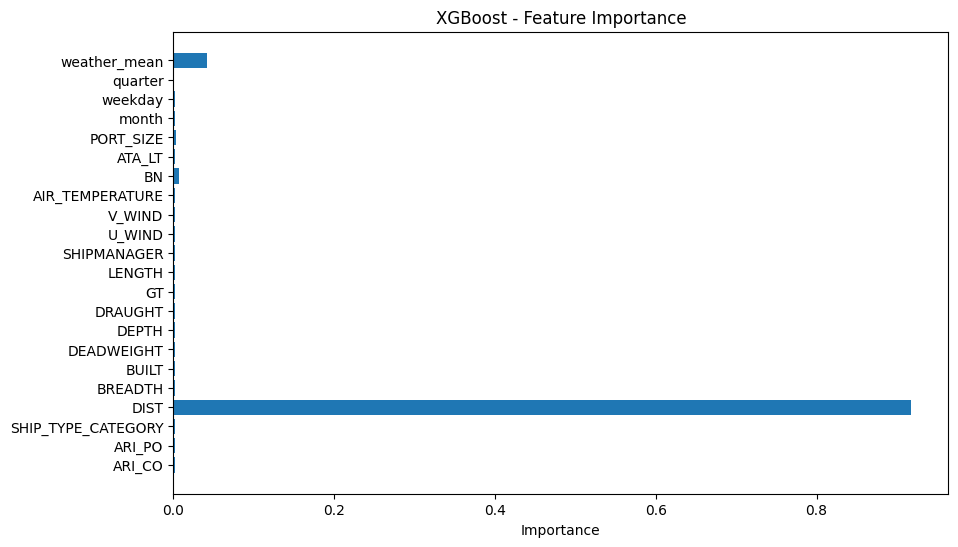

[0]	validation_0-mae:64.05683
[1000]	validation_0-mae:2.79408
[2000]	validation_0-mae:2.73594
[3000]	validation_0-mae:2.72455
[4000]	validation_0-mae:2.72231
[5000]	validation_0-mae:2.72000
[6000]	validation_0-mae:2.71944
[7000]	validation_0-mae:2.71903
[8000]	validation_0-mae:2.71805
[9000]	validation_0-mae:2.71797
[9922]	validation_0-mae:2.71783
Mae : 2.7162630858756383


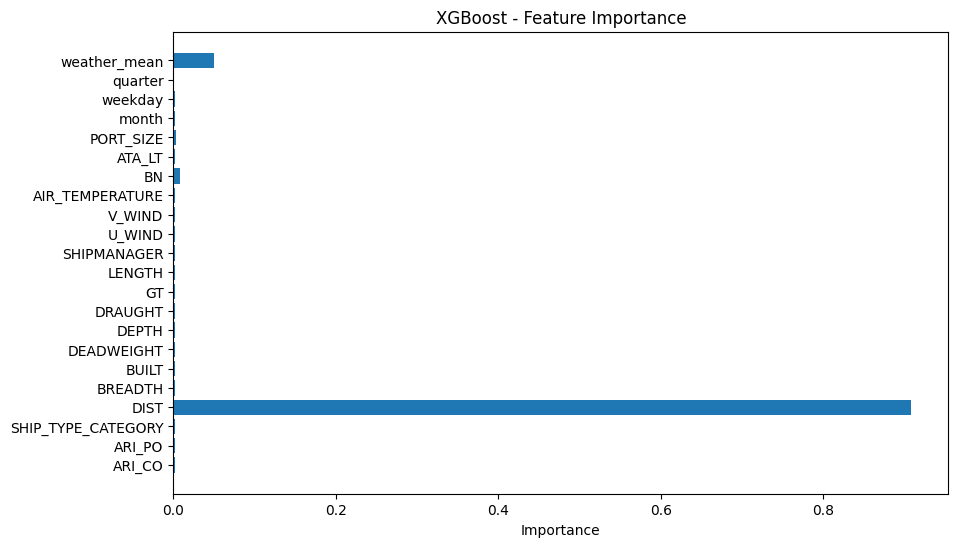

[0]	validation_0-mae:63.92924
[1000]	validation_0-mae:3.09928
[2000]	validation_0-mae:3.05952
[3000]	validation_0-mae:3.05384
[4000]	validation_0-mae:3.05251
[5000]	validation_0-mae:3.05203
[6000]	validation_0-mae:3.05131
[7000]	validation_0-mae:3.04996
[8000]	validation_0-mae:3.04927
[9000]	validation_0-mae:3.04916
[10000]	validation_0-mae:3.04900
[11000]	validation_0-mae:3.04871
[12000]	validation_0-mae:3.04837
[13000]	validation_0-mae:3.04813
[14000]	validation_0-mae:3.04790
[15000]	validation_0-mae:3.04771
[16000]	validation_0-mae:3.04760
[17000]	validation_0-mae:3.04739
[18000]	validation_0-mae:3.04712
[19000]	validation_0-mae:3.04697
[20000]	validation_0-mae:3.04693
[21000]	validation_0-mae:3.04673
[22000]	validation_0-mae:3.04684
[22313]	validation_0-mae:3.04688
Mae : 3.0460627023747193


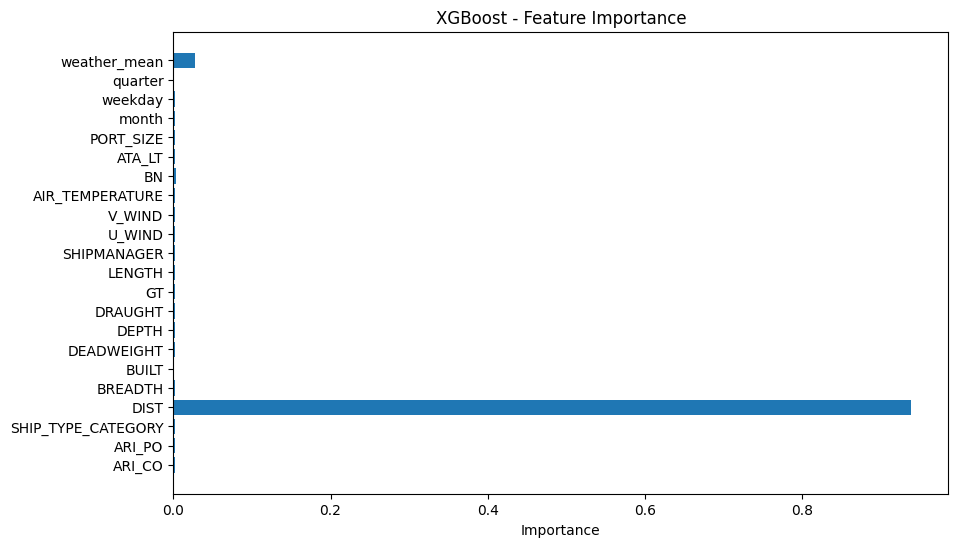

[0]	validation_0-mae:64.01514
[1000]	validation_0-mae:2.72952
[2000]	validation_0-mae:2.68965
[3000]	validation_0-mae:2.67732
[4000]	validation_0-mae:2.67537
[5000]	validation_0-mae:2.67531
[6000]	validation_0-mae:2.67484
[7000]	validation_0-mae:2.67441
[8000]	validation_0-mae:2.67400
[9000]	validation_0-mae:2.67341
[10000]	validation_0-mae:2.67316
[10616]	validation_0-mae:2.67321
Mae : 2.671846682388761


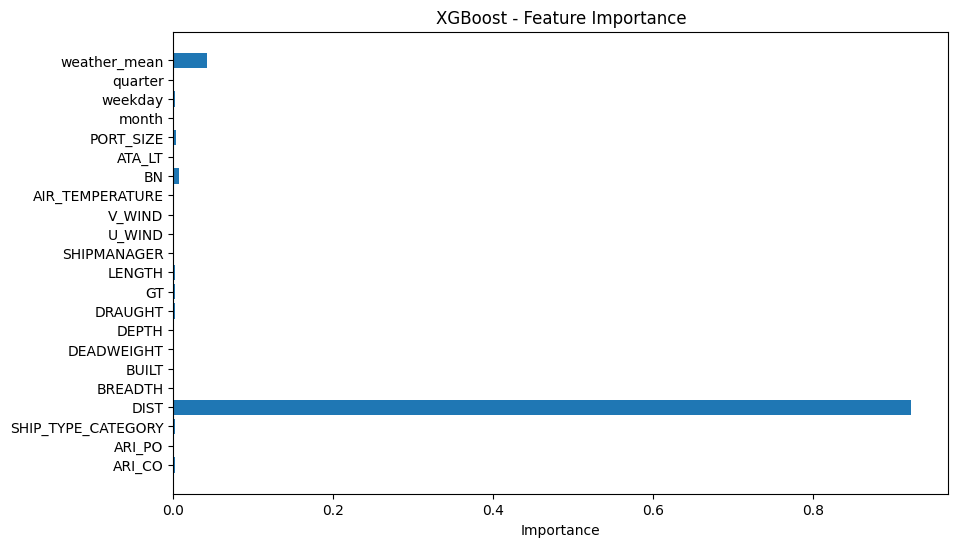

[0]	validation_0-mae:64.17190
[1000]	validation_0-mae:3.00061
[2000]	validation_0-mae:2.94729
[3000]	validation_0-mae:2.93023
[4000]	validation_0-mae:2.92700
[5000]	validation_0-mae:2.92529
[6000]	validation_0-mae:2.92464
[7000]	validation_0-mae:2.92446
[8000]	validation_0-mae:2.92412
[9000]	validation_0-mae:2.92409
[10000]	validation_0-mae:2.92400
[11000]	validation_0-mae:2.92370
[12000]	validation_0-mae:2.92360
[12130]	validation_0-mae:2.92360
Mae : 2.9216927294584227


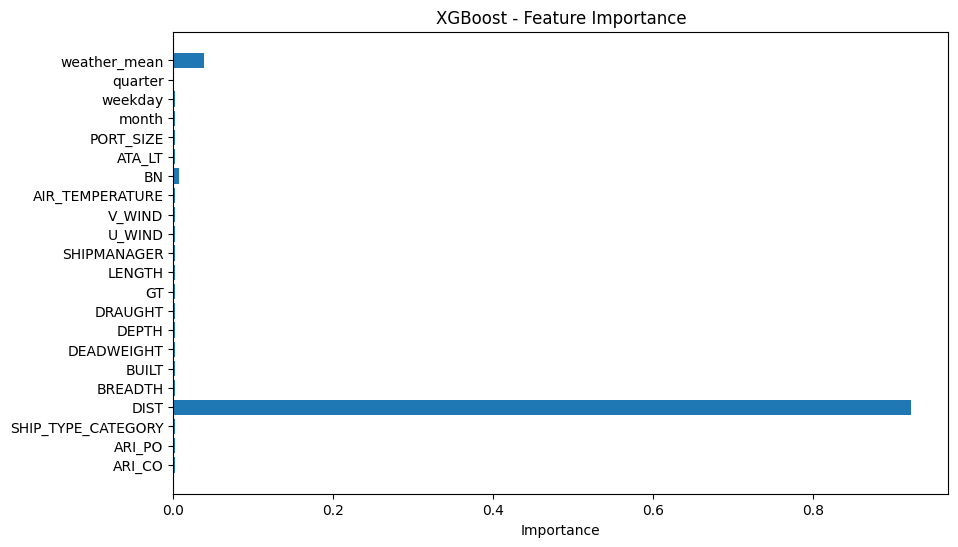

XGBRegressor의 5fold 평균 MAE는 2.81592619454458


In [ ]:
model = XGBRegressor(objective = 'reg:absoluteerror',
                     eta = 0.01,
                     n_estimators = 1000000,
                     max_depth = 11,
                     min_child_weight = 15,
                     max_delta_step = 15,
                     colsample_bytree = 1,
                     alpha = 0,
                     reg_lambda = 1,
                     gamma = 0,
                     max_bin = 2048,
                     eval_metric= 'mae',
                     early_stopping_rounds=1000,
                     verbosity = 1,
                     n_jobs = -1,
                     seed=CFG.SEED)

XGB_pred_01 = np.zeros((X_test_01.shape[0]))
mae_list_01 = []
for tr_idx, val_idx in kf.split(X_train_01, y_train_01):
    tr_x, tr_y = X_train_01.iloc[tr_idx], y_train_01.iloc[tr_idx]
    val_x, val_y = X_train_01.iloc[val_idx], y_train_01.iloc[val_idx]
    model.fit(tr_x, tr_y, eval_set=[(val_x, val_y)], verbose=1000)
    pred = model.predict(val_x)
    pred = np.clip(pred, 0, np.inf)

    mae = mean_absolute_error(val_y, pred)
    mae_list_01.append(mae)

    print('Mae :', mae)

    feature_importance_01 = model.feature_importances_
    feature_names_01 = X_train_01.columns
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names_01, feature_importance_01, align='center')
    plt.title('XGBoost - Feature Importance')
    plt.xlabel('Importance')
    plt.show()


    sub_pred_01 = model.predict(X_test_01)
    sub_pred_01 = np.clip(sub_pred_01, 0, np.inf)
    sub_pred_01 = np.array(sub_pred_01)/5

    XGB_pred_01 += sub_pred_01
print(f'{model.__class__.__name__}의 5fold 평균 MAE는 {np.mean(mae_list_01)}')

In [ ]:
"""
def objective(trial):
    params = {
        "n_estimators": 10000,
        "verbosity" : 0,
        "seed" : CFG.SEED,
        "n_jobs" : -1,
        "eta": 0.1,
        "max_depth": 7,
        "objective" : 'reg:absoluteerror',
        "early_stopping_rounds": 100,
        "eval_metric" : 'mae',
        "gamma": trial.suggest_int("gamma", 0, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 0, 10),
        "max_delta_step": trial.suggest_float("max_delta_step", 0, 10),
        "colsample_bytree" : trial.suggest_categorical("colsample_bytree", [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]),
        "lambda": trial.suggest_int("lambda", 0, 10),
        "alpha": trial.suggest_int("alpha", 0, 10),
        "max_bin": trial.suggest_categorical("max_bin",[32, 64, 128, 256, 512, 1024, 2048]),
    }

    model = XGBRegressor(**params)
    XGB_pred_02 = np.zeros((X_test_02.shape[0]))
    mae_list = []
    for tr_idx, val_idx in kf.split(X_train_02, y_train_02):
        tr_x, tr_y = X_train_02.iloc[tr_idx], y_train_02.iloc[tr_idx]
        val_x, val_y = X_train_02.iloc[val_idx], y_train_02.iloc[val_idx]
        model.fit(tr_x, tr_y, eval_set=[(val_x, val_y)], verbose = 0)
        pred = model.predict(val_x)
        pred = np.clip(pred, 0, np.inf)

        mae = mean_absolute_error(val_y, pred)
        mae_list.append(mae)

        print('Mae :', mae)

    return np.mean(mae_list)
"""

'\ndef objective(trial):\n    params = {\n        "n_estimators": 10000,\n        "verbosity" : 0,\n        "seed" : CFG.SEED,\n        "n_jobs" : -1,\n        "eta": 0.1,\n        "max_depth": 7,\n        "objective" : \'reg:absoluteerror\',\n        "early_stopping_rounds": 100,\n        "eval_metric" : \'mae\',\n        "gamma": trial.suggest_int("gamma", 0, 10),\n        "min_child_weight": trial.suggest_int("min_child_weight", 0, 10),\n        "max_delta_step": trial.suggest_float("max_delta_step", 0, 10),\n        "colsample_bytree" : trial.suggest_categorical("colsample_bytree", [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]),\n        "lambda": trial.suggest_int("lambda", 0, 10),\n        "alpha": trial.suggest_int("alpha", 0, 10),\n        "max_bin": trial.suggest_categorical("max_bin",[32, 64, 128, 256, 512, 1024, 2048]),\n    }\n\n    model = XGBRegressor(**params)\n    XGB_pred_02 = np.zeros((X_test_02.shape[0]))\n    mae_list = []\n    for tr_idx, val_idx in kf.split(X_t

In [ ]:
"""
pruner_02 = optuna.pruners.MedianPruner(n_warmup_steps=5)
study_02 = optuna.create_study(pruner=pruner_02, direction="minimize",sampler=TPESampler(seed=CFG.SEED))
study_02.optimize(objective, n_trials=200)

print("Number of finished trials: {}".format(len(study_02.trials)))

print("Best trial:")
trial = study_02.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
"""

'\npruner_02 = optuna.pruners.MedianPruner(n_warmup_steps=5)\nstudy_02 = optuna.create_study(pruner=pruner_02, direction="minimize",sampler=TPESampler(seed=CFG.SEED))\nstudy_02.optimize(objective, n_trials=200)\n\nprint("Number of finished trials: {}".format(len(study_02.trials)))\n\nprint("Best trial:")\ntrial = study_02.best_trial\n\nprint("  Value: {}".format(trial.value))\n\nprint("  Params: ")\nfor key, value in trial.params.items():\n    print("    {}: {}".format(key, value))\n'

[0]	validation_0-mae:55.87305
[1000]	validation_0-mae:40.79767
[2000]	validation_0-mae:40.30845
[3000]	validation_0-mae:39.95054
[4000]	validation_0-mae:39.79885
[5000]	validation_0-mae:39.64567
[6000]	validation_0-mae:39.59465
[7000]	validation_0-mae:39.48598
[8000]	validation_0-mae:39.43132
[9000]	validation_0-mae:39.39080
[10000]	validation_0-mae:39.34016
[11000]	validation_0-mae:39.30396
[12000]	validation_0-mae:39.26021
[13000]	validation_0-mae:39.23368
[14000]	validation_0-mae:39.21829
[15000]	validation_0-mae:39.20784
[16000]	validation_0-mae:39.19800
[17000]	validation_0-mae:39.18739
[18000]	validation_0-mae:39.17734
[19000]	validation_0-mae:39.17606
[20000]	validation_0-mae:39.17287
[21000]	validation_0-mae:39.16557
[22000]	validation_0-mae:39.16410
[23000]	validation_0-mae:39.15996
[24000]	validation_0-mae:39.15278
[25000]	validation_0-mae:39.14954
[26000]	validation_0-mae:39.14476
[27000]	validation_0-mae:39.14074
[28000]	validation_0-mae:39.13824
[29000]	validation_0-mae:39

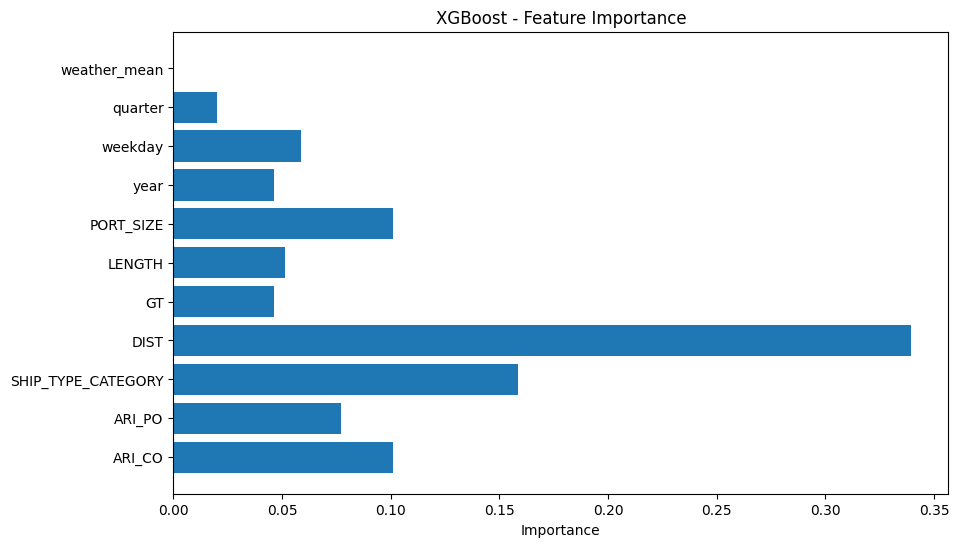

[0]	validation_0-mae:55.51833
[1000]	validation_0-mae:40.70810
[2000]	validation_0-mae:40.13712
[3000]	validation_0-mae:39.73491
[4000]	validation_0-mae:39.49865
[5000]	validation_0-mae:39.36063
[6000]	validation_0-mae:39.26086
[7000]	validation_0-mae:39.21330
[8000]	validation_0-mae:39.16001
[9000]	validation_0-mae:39.12407
[10000]	validation_0-mae:39.09684
[11000]	validation_0-mae:39.08490
[12000]	validation_0-mae:39.05979
[13000]	validation_0-mae:39.04631
[14000]	validation_0-mae:39.04041
[15000]	validation_0-mae:39.03359
[16000]	validation_0-mae:39.02307
[17000]	validation_0-mae:39.01731
[18000]	validation_0-mae:38.99822
[19000]	validation_0-mae:38.99149
[20000]	validation_0-mae:38.99081
[21000]	validation_0-mae:38.98424
[22000]	validation_0-mae:38.98146
[23000]	validation_0-mae:38.97601
[24000]	validation_0-mae:38.97224
[25000]	validation_0-mae:38.97309
[26000]	validation_0-mae:38.96636
[27000]	validation_0-mae:38.96377
[28000]	validation_0-mae:38.95916
[29000]	validation_0-mae:38

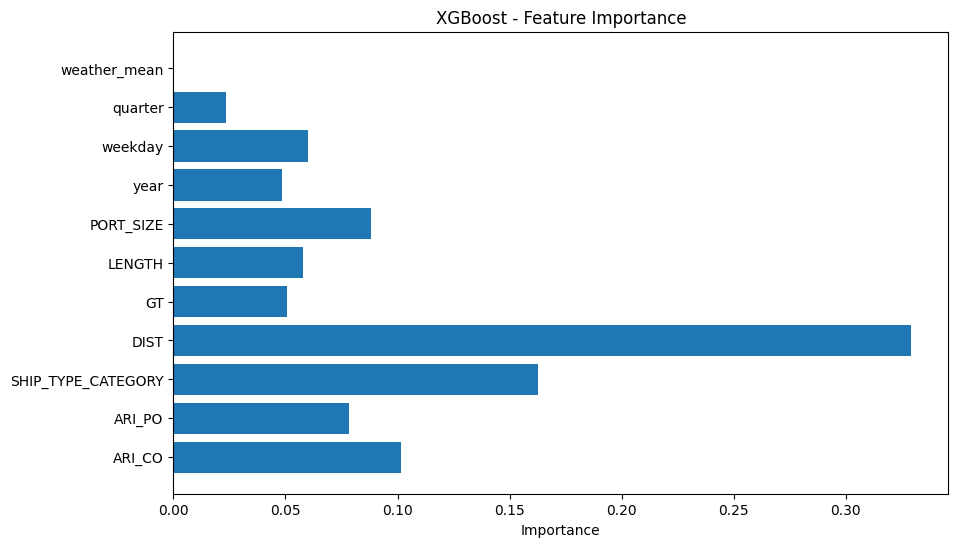

[0]	validation_0-mae:56.51582
[1000]	validation_0-mae:40.64020
[2000]	validation_0-mae:40.12851
[3000]	validation_0-mae:39.79371
[4000]	validation_0-mae:39.63206
[5000]	validation_0-mae:39.48777
[6000]	validation_0-mae:39.46234
[7000]	validation_0-mae:39.40930
[8000]	validation_0-mae:39.34958
[9000]	validation_0-mae:39.31322
[10000]	validation_0-mae:39.27033
[11000]	validation_0-mae:39.24901
[12000]	validation_0-mae:39.21914
[13000]	validation_0-mae:39.20860
[14000]	validation_0-mae:39.19079
[15000]	validation_0-mae:39.17416
[16000]	validation_0-mae:39.15986
[17000]	validation_0-mae:39.14769
[18000]	validation_0-mae:39.13447
[19000]	validation_0-mae:39.12233
[20000]	validation_0-mae:39.12181
[21000]	validation_0-mae:39.11370
[22000]	validation_0-mae:39.10118
[23000]	validation_0-mae:39.08966
[24000]	validation_0-mae:39.07930
[25000]	validation_0-mae:39.07109
[26000]	validation_0-mae:39.06181
[27000]	validation_0-mae:39.05733
[28000]	validation_0-mae:39.05401
[29000]	validation_0-mae:39

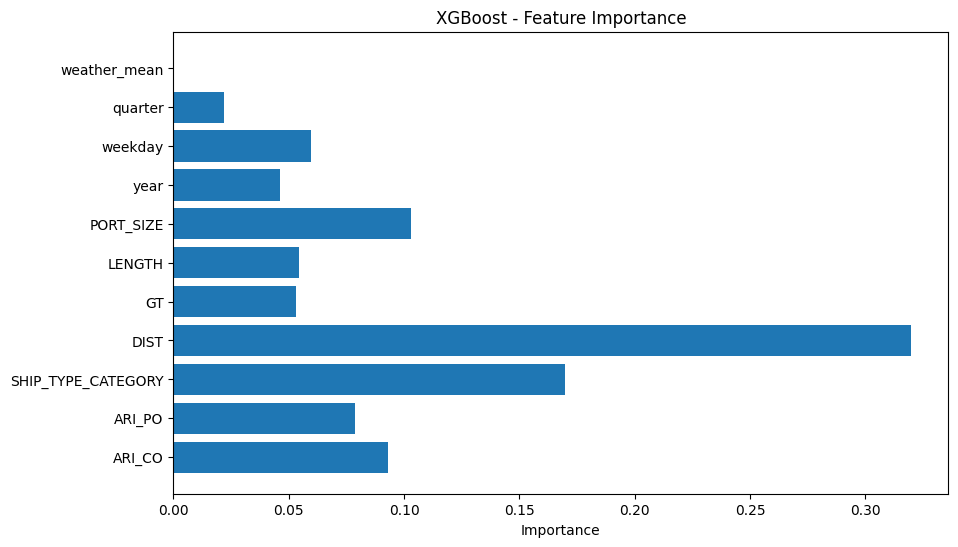

[0]	validation_0-mae:55.81569
[1000]	validation_0-mae:40.30608
[2000]	validation_0-mae:39.60819
[3000]	validation_0-mae:39.28720
[4000]	validation_0-mae:39.08387
[5000]	validation_0-mae:38.94423
[6000]	validation_0-mae:38.85224
[7000]	validation_0-mae:38.80786
[8000]	validation_0-mae:38.76369
[9000]	validation_0-mae:38.75023
[10000]	validation_0-mae:38.71183
[11000]	validation_0-mae:38.67994
[12000]	validation_0-mae:38.65801
[13000]	validation_0-mae:38.63920
[14000]	validation_0-mae:38.61523
[15000]	validation_0-mae:38.60152
[16000]	validation_0-mae:38.58589
[17000]	validation_0-mae:38.57228
[18000]	validation_0-mae:38.55961
[19000]	validation_0-mae:38.54891
[20000]	validation_0-mae:38.53722


In [ ]:
model =  XGBRegressor(objective = 'reg:absoluteerror',
                      eta=0.01,
                      n_estimators = 100000,
                      max_depth = 7,
                      min_child_weight = 10,
                      max_delta_step = 2.2152489372607116,
                      colsample_bytree = 0.8,
                      alpha =4,
                      reg_lambda = 7,
                      gamma = 0,
                      max_bin = 64,
                      eval_metric= 'mae',
                      early_stopping_rounds=1000,
                      verbosity = 1,
                      n_jobs = -1,
                      seed=CFG.SEED)
XGB_pred_02 = np.zeros((X_test_02.shape[0]))
mae_list_02 = []
for tr_idx, val_idx in kf.split(X_train_02, y_train_02):
    tr_x, tr_y = X_train_02.iloc[tr_idx], y_train_02.iloc[tr_idx]
    val_x, val_y = X_train_02.iloc[val_idx], y_train_02.iloc[val_idx]
    model.fit(tr_x, tr_y, eval_set=[(val_x, val_y)], verbose=1000)
    pred = model.predict(val_x)
    pred = np.clip(pred, 0, np.inf)

    mae = mean_absolute_error(val_y, pred)
    mae_list_02.append(mae)

    print('Mae :', mae)

    feature_importance_02 = model.feature_importances_
    feature_names_02 = X_train_02.columns
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names_02, feature_importance_02, align='center')
    plt.title('XGBoost - Feature Importance')
    plt.xlabel('Importance')
    plt.show()


    sub_pred_02 = model.predict(X_test_02)
    sub_pred_02 = np.clip(sub_pred_02, 0, np.inf)
    sub_pred_02 = np.array(sub_pred_02)/5

    XGB_pred_02 += sub_pred_02
print(f'{model.__class__.__name__}의 5fold 평균 MAE는 {np.mean(mae_list_02)}')

### Submit

In [ ]:
submit_01 = pd.read_csv(DATA_PATH + 'sample_submission.csv')

In [ ]:
submit_01.loc[X_test_01_index, 'CI_HOUR'] = XGB_pred_01
submit_01.loc[X_test_02_index, 'CI_HOUR'] = XGB_pred_02

In [ ]:
submit_01.to_csv(DATA_PATH + f'XGB_{CFG.SEED}_{np.mean(mae_list_02)}.csv',index=False)

## Pipeline_02(CatBoostRegressor)

In [ ]:
train_02 = train_02[train_02['BREADTH'].notnull()].reset_index(drop=True)

In [ ]:
train_02['ATA'] = pd.to_datetime(train_02['ATA'])
test_02['ATA'] = pd.to_datetime(test_02['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train_02, test_02]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

train_02['ARI_CO-PO'] = train_02['ARI_CO'] + '-' + train_02['ARI_PO']
test_02['ARI_CO-PO'] = test_02['ARI_CO'] + '-' + test_02['ARI_PO']

In [ ]:
train_02.loc[(train_02['U_WIND'] == 0) & (train_02['V_WIND'] == 0) & (train_02['AIR_TEMPERATURE'].isnull()) & (train_02['BN'] == 0), ['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN']] = np.nan

In [ ]:
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'FLAG','SHIPMANAGER','year', 'month', 'day', 'hour','minute', 'weekday','ARI_CO-PO']
numeric_features = list(set(train_02.columns)-set(categorical_features))

In [ ]:
train_02 = pd.merge(train_02,train_02.groupby(['ARI_CO','ARI_PO']).CI_HOUR.mean().reset_index().rename(columns={'CI_HOUR':'CO_PO_mean'}),how = 'left',on = ['ARI_CO','ARI_PO'])
test_02 = pd.merge(test_02,train_02.groupby(['ARI_CO','ARI_PO']).CI_HOUR.mean().reset_index().rename(columns={'CI_HOUR':'CO_PO_mean'}),how = 'left',on = ['ARI_CO','ARI_PO'])
test_02['CO_PO_mean'] = test_02['CO_PO_mean'].fillna(train_02['CO_PO_mean'].mean())

In [ ]:
train_02 = pd.merge(train_02,train_02.groupby(['ARI_PO','ARI_CO','month','year']).CI_HOUR.mean().reset_index().rename(columns={'CI_HOUR':'CO_PO_ym_mean'}),how = 'left',on = ['ARI_PO','ARI_CO','month','year'])
test_02 = pd.merge(test_02,train_02.groupby(['ARI_PO','ARI_CO','month','year']).CI_HOUR.mean().reset_index().rename(columns={'CI_HOUR':'CO_PO_ym_mean'}),how = 'left',on = ['ARI_PO','ARI_CO','month','year'])
test_02['CO_PO_ym_mean'] = test_02['CO_PO_ym_mean'].fillna(train_02['CO_PO_ym_mean'].mean())

In [ ]:
train_02 = pd.merge(train_02,train_02.groupby(['ARI_PO','ARI_CO','SHIP_TYPE_CATEGORY','year']).CI_HOUR.mean().reset_index().rename(columns={'CI_HOUR':'CO_PO_SH_y_mean'}),how = 'left',on = ['ARI_PO','ARI_CO','SHIP_TYPE_CATEGORY','year'])
test_02 = pd.merge(test_02,train_02.groupby(['ARI_PO','ARI_CO','SHIP_TYPE_CATEGORY','year']).CI_HOUR.mean().reset_index().rename(columns={'CI_HOUR':'CO_PO_SH_y_mean'}),how = 'left',on = ['ARI_PO','ARI_CO','SHIP_TYPE_CATEGORY','year'])
test_02['CO_PO_SH_y_mean'] = test_02['CO_PO_SH_y_mean'].fillna(train_02['CO_PO_SH_y_mean'].mean())

In [ ]:
# encoding
for i in tqdm(categorical_features):
    le = LabelEncoder()
    le=le.fit(train_02[i])
    train_02[i]=le.transform(train_02[i])

    for label in np.unique(test_02[i]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test_02[i]=le.transform(test_02[i])

In [ ]:
train_02['BTA'] = train_02['ATA'] + pd.to_timedelta(train_02['CI_HOUR'], 'h')

In [ ]:
BTA_mean_02 = pd.pivot_table(train_02, values = 'BTA', index = ['ARI_CO', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN'], aggfunc = np.mean).reset_index()
BTA_mean_02 = BTA_mean_02.rename(columns={'BTA':'BTA_mean_02'})

train_02 = pd.merge(train_02, BTA_mean_02, how='left', on=['ARI_CO', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN'])
test_02 = pd.merge(test_02, BTA_mean_02, how='left', on=['ARI_CO', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN'])

In [ ]:
train_02['weather_mean'] = (train_02['BTA_mean_02']-train_02['ATA'])/pd.to_timedelta(1,'h')
test_02['weather_mean'] = (test_02['BTA_mean_02']-test_02['ATA'])/pd.to_timedelta(1,'h')

In [ ]:
train_02['weather_mean'] = train_02['weather_mean'].apply(lambda x:0 if x<0 else x)
test_02['weather_mean'] = test_02['weather_mean'].apply(lambda x:0 if x<0 else x)

In [ ]:
train_02 = train_02.drop(columns = ['ATA','BTA','BTA_mean_02'])
test_02 = test_02.drop(columns = ['ATA','BTA_mean_02'])

In [ ]:
X_train_03 = train_02[train_02['weather_mean'].notnull()].query('DIST>0')
X_train_04 = train_02[train_02['weather_mean'].isnull()].query('DIST>0')

X_test_03 = test_02[test_02['weather_mean'].notnull()].query('DIST>0')
X_test_04 = test_02[test_02['weather_mean'].isnull()].query('DIST>0')

X_test_03_index = X_test_03.index
X_test_04_index = X_test_04.index

In [ ]:
X_train_03 = X_train_03.reset_index(drop=True)
X_train_04 = X_train_04.reset_index(drop=True)

X_test_03 = X_test_03.reset_index(drop=True)
X_test_04 = X_test_04.reset_index(drop=True)

In [ ]:
y_train_03 = X_train_03['CI_HOUR']
X_train_03 = X_train_03.drop(columns = 'CI_HOUR')

y_train_04 = X_train_04['CI_HOUR']
X_train_04 = X_train_04.drop(columns = 'CI_HOUR')

In [ ]:
X_train_03 = X_train_03.drop(columns = ['ID', 'day', 'hour', 'minute','ARI_CO','ARI_PO','BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT','SHIPMANAGER', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE','ATA_LT'])
X_test_03 = X_test_03.drop(columns = ['ID', 'day', 'hour', 'minute','ARI_CO','ARI_PO','BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT','SHIPMANAGER', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE','ATA_LT'])

X_train_04 = X_train_04.drop(columns=['ID','day', 'hour', 'minute','BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT','SHIPMANAGER', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE','ATA_LT','BN','weather_mean'])
X_test_04 = X_test_04.drop(columns=['ID','day', 'hour', 'minute','BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT','SHIPMANAGER', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE','ATA_LT','BN','weather_mean'])

### MODELING

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=CFG.SEED)

In [ ]:
model_03 = CatBoostRegressor(n_estimators=200000, eval_metric='MAE',loss_function='MAE', random_state = CFG.SEED)
cat_pred_01 = np.zeros((X_test_03.shape[0]))
mae_list_03 = []
for tr_idx, val_idx in kf.split(X_train_03, y_train_03):
    tr_x, tr_y = X_train_03.iloc[tr_idx], y_train_03.iloc[tr_idx]
    val_x, val_y = X_train_03.iloc[val_idx], y_train_03.iloc[val_idx]
    model_03.fit(tr_x, tr_y, eval_set=[(val_x, val_y)],early_stopping_rounds = 50, verbose = 1000)
    pred = model_03.predict(val_x)
    pred = np.clip(pred, 0, np.inf)

    mae = mean_absolute_error(val_y, pred)
    mae_list_03.append(mae)

    sub_pred_03 = model_03.predict(X_test_03)
    sub_pred_03 = np.clip(sub_pred_03, 0, np.inf)
    sub_pred_03 = np.array(sub_pred_03)/5

    cat_pred_01 += sub_pred_03
print(f'{model_03.__class__.__name__}의 5fold 평균 MAE는 {np.mean(mae_list_03)}')

In [ ]:
model_04 = CatBoostRegressor(n_estimators=200000, eval_metric='MAE',loss_function='MAE', random_state = CFG.SEED)
cat_pred_02 = np.zeros((X_test_04.shape[0]))
mae_list_04 = []
for tr_idx, val_idx in kf.split(X_train_04, y_train_04):
    tr_x, tr_y = X_train_04.iloc[tr_idx], y_train_04.iloc[tr_idx]
    val_x, val_y = X_train_04.iloc[val_idx], y_train_04.iloc[val_idx]
    model_04.fit(tr_x, tr_y, eval_set=[(val_x, val_y)],early_stopping_rounds = 50, verbose = 1000)
    pred = model_04.predict(val_x)
    pred = np.clip(pred, 0, np.inf)

    mae = mean_absolute_error(val_y, pred)
    mae_list_04.append(mae)

    sub_pred_04 = model_04.predict(X_test_04)
    sub_pred_04 = np.clip(sub_pred_04, 0, np.inf)
    sub_pred_04 = np.array(sub_pred_04)/5

    cat_pred_02 += sub_pred_04
print(f'{model_04.__class__.__name__}의 5fold 평균 MAE는 {np.mean(mae_list_04)}')

### Submit

In [ ]:
submit_02 = pd.read_csv(DATA_PATH + 'sample_submission.csv')

In [ ]:
submit_02.loc[X_test_03_index, 'CI_HOUR'] = cat_pred_01
submit_02.loc[X_test_04_index, 'CI_HOUR'] = cat_pred_02

In [ ]:
te_index = test_02[test_02['DIST']==0].index
submit_02.loc[te_index, 'CI_HOUR'] = 0

In [ ]:
submit_02.to_csv(DATA_PATH + f'CAT_{CFG.SEED}_{np.mean(mae_list_04)}.csv',index=False)

## Submission

In [ ]:
submit_03 = pd.read_csv(DATA_PATH + 'sample_submission.csv')

In [ ]:
submit_03['CI_HOUR'] = submit_01['CI_HOUR']*0.5 + submit_02['CI_HOUR']*0.5

In [ ]:
submit_03.to_csv(DATA_PATH + f'XGB+CAT_{CFG.SEED}.csv',index=False)